# Plot linear regression fits

In [1]:
import numpy as np
import brainlit
import scipy
from brainlit.utils import swc
from cloudvolume.exceptions import SkeletonDecodeError
from brainlit.algorithms.trace_analysis.fit_spline import GeometricGraph
from brainlit.algorithms.trace_analysis.spline_fxns import curvature, torsion
import os
from pathlib import Path
import pandas as pd
from networkx.readwrite import json_graph
import json
import matplotlib.pyplot as plt

/cis/home/jteneggi/anaconda3/envs/cuda10/lib/python3.8/site-packages/python_jsonschema_objects/__init__.py:50: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  warnings.warn(


## Define brain, find trace data folder

In [2]:
#specify brain1 or brain2 below
brain = "brain1"

root_dir = Path(os.path.abspath('')).parents[1]
experiment_dir = os.path.join(root_dir, "axon_geometry")
data_dir = os.path.join(experiment_dir, "data", brain)
segments_swc_dir = os.path.join(data_dir, "segments_swc")
trace_data_dir = os.path.join(data_dir, "trace_data")
trace_data_dir = os.path.join(trace_data_dir, "14")
print(f"Directory where swcs reside: {segments_swc_dir}")

Directory where swcs reside: /cis/home/jteneggi/repo/brainlit/experiments/axon_geometry/data/brain1/segments_swc


## Read trace data

In [3]:
max_id = 300
seg_lengths = []
mean_torsions = []
mean_curvatures = []
d_from_root = []
torsions = []
curvatures = []
df = pd.DataFrame(columns=["log_seg_length", "log_mean_curvature", "log_mean_torsion"])
for i in np.arange(0, max_id):
    i = int(i)
    trace_data_path = os.path.join(trace_data_dir, "{}.npy".format(i))
    if os.path.exists(trace_data_path) is True:
        trace_data = np.load(trace_data_path, allow_pickle=True)
        print("Loaded segment {}".format(i))

        for node in trace_data:
            # print(node)
            seg_length = node["seg_length"]
            mean_curvature = node["mean_curvature"]
            mean_torsion = node["mean_torsion"]
            seg_lengths.append(node["seg_length"])
            mean_curvatures.append(node["mean_curvature"])
            mean_torsions.append(node["mean_torsion"])
            if mean_curvature > 1e-16 and mean_torsion > 1e-16:
                log_seg_length = np.log10(seg_length)
                log_mean_curvature = np.log10(mean_curvature)
                log_mean_torsion = np.log10(mean_torsion)
                df = df.append({"log_seg_length": log_seg_length, "log_mean_curvature": log_mean_curvature, "log_mean_torsion": log_mean_torsion}, ignore_index=True)
            
seg_lengths = np.array(seg_lengths)
mean_curvatures = np.array(mean_curvatures)
mean_torsions = np.array(mean_torsions)

Loaded segment 2
Loaded segment 7
Loaded segment 11
Loaded segment 12
Loaded segment 13
Loaded segment 14
Loaded segment 20
Loaded segment 24
Loaded segment 28
Loaded segment 35
Loaded segment 40
Loaded segment 45
Loaded segment 48
Loaded segment 49
Loaded segment 51
Loaded segment 53
Loaded segment 59
Loaded segment 60
Loaded segment 65
Loaded segment 67
Loaded segment 73
Loaded segment 75
Loaded segment 77
Loaded segment 78
Loaded segment 79
Loaded segment 82
Loaded segment 83
Loaded segment 85
Loaded segment 86
Loaded segment 91
Loaded segment 98
Loaded segment 101
Loaded segment 103
Loaded segment 106
Loaded segment 120
Loaded segment 124
Loaded segment 136
Loaded segment 140
Loaded segment 141
Loaded segment 142
Loaded segment 143
Loaded segment 144
Loaded segment 145
Loaded segment 146
Loaded segment 147
Loaded segment 149
Loaded segment 150
Loaded segment 152
Loaded segment 153
Loaded segment 154
Loaded segment 155
Loaded segment 156
Loaded segment 157
Loaded segment 158
Loaded 

## Fit curvatures

In [4]:
nonzero_mean_curvatures_masked = np.ma.masked_less(mean_curvatures, 1e-16)
nonzero_mean_curvatures = nonzero_mean_curvatures_masked.compressed()
nonzero_mean_curvatures_seg_lengths = seg_lengths[nonzero_mean_curvatures_masked.mask == 0]

log_mean_curvatures = np.log10(nonzero_mean_curvatures)
log_curvatures_seg_lengths = np.log10(nonzero_mean_curvatures_seg_lengths)

log_slope_curvatures, log_intercept_curvatures, _, _, _ = scipy.stats.linregress(
    log_curvatures_seg_lengths, log_mean_curvatures
)
log_slope_curvatures = np.around(log_slope_curvatures, decimals=2)
log_intercept_curvatures = np.around(log_intercept_curvatures, decimals=2)
log_curvatures_fit = (
    log_slope_curvatures * log_curvatures_seg_lengths + log_intercept_curvatures
)
curvatures_pearson_r, curvatures_p_value = scipy.stats.pearsonr(
    log_mean_curvatures, log_curvatures_fit
)
print(
    log_slope_curvatures,
    log_intercept_curvatures,
    curvatures_pearson_r ** 2,
    curvatures_p_value,
)

n = len(log_curvatures_seg_lengths)
print(f"{n} data points in the curvature plot")

-0.28 -0.86 0.19227446770555467 0.0
14239 data points in the curvature plot


## Fit torsions

In [5]:
nonzero_mean_torsions_masked = np.ma.masked_less(mean_torsions, 1e-16)
nonzero_mean_torsions = nonzero_mean_torsions_masked.compressed()
nonzero_mean_torsions_seg_lengths = seg_lengths[nonzero_mean_torsions_masked.mask == 0]

log_mean_torsions = np.log10(nonzero_mean_torsions)
log_torsions_seg_lengths = np.log10(nonzero_mean_torsions_seg_lengths)

log_slope_torsions, log_intercept_torsions, _, _, _ = scipy.stats.linregress(
    log_torsions_seg_lengths, log_mean_torsions
)
log_slope_torsions = np.around(log_slope_torsions, decimals=2)
log_intercept_torsions = np.around(log_intercept_torsions, decimals=2)
log_torsions_fit = (
    log_slope_torsions * log_torsions_seg_lengths + log_intercept_torsions
)
torsions_pearson_r, torsions_p_value = scipy.stats.pearsonr(
    log_mean_torsions, log_torsions_fit
)
print(
    log_slope_torsions,
    log_intercept_torsions,
    torsions_pearson_r ** 2,
    torsions_p_value,
)

n = len(log_torsions_seg_lengths)
print(f"{n} data points in the torsion plot")

0.2 -1.72 0.03668530010079597 9.537249521136807e-95
11413 data points in the torsion plot


## Plot figure

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


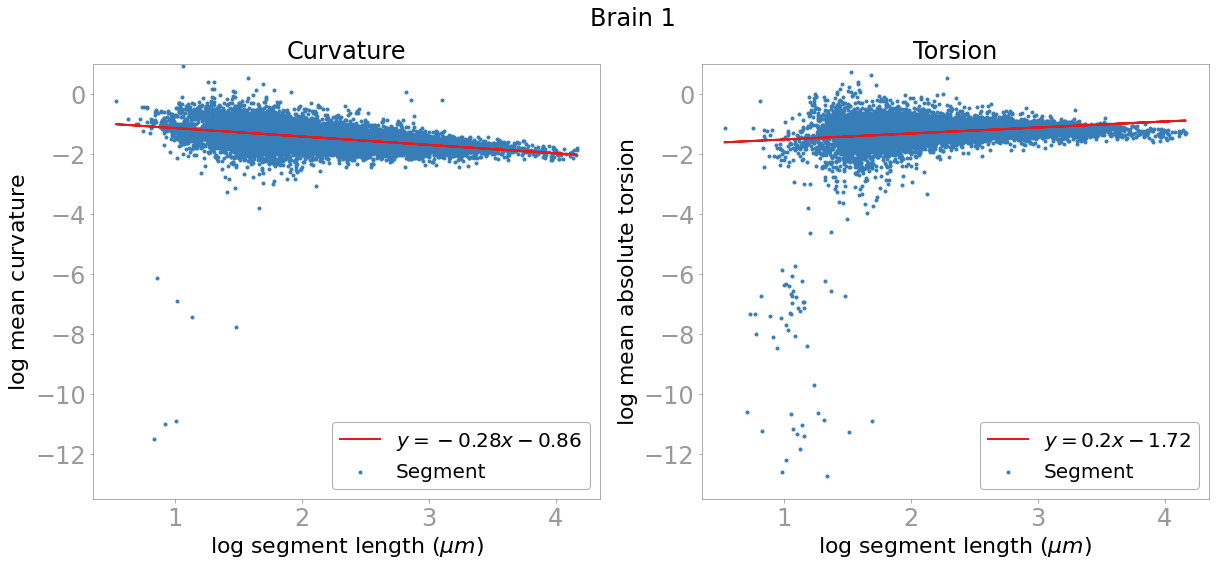

In [6]:
fig = plt.figure(figsize=(20, 8))
axes = fig.subplots(1, 2)
GRAY = "#999999"
TITLE_TYPE_SETTINGS = {"fontname": "Arial", "size": 20}
SUP_TITLE_TYPE_SETTINGS = {"fontname": "Arial", "size": 24}
plt.rc("font", family="Arial", size=20)

ax = axes[0]
ax.spines["bottom"].set_color(GRAY)
ax.spines["top"].set_color(GRAY)
ax.spines["right"].set_color(GRAY)
ax.spines["left"].set_color(GRAY)
ax.tick_params(axis="both", colors=GRAY, labelsize="large")

ax.scatter(
    log_curvatures_seg_lengths,
    log_mean_curvatures,
    marker=".",
    label="Segment",
    color="#377eb8",
)
ax.plot(
    log_curvatures_seg_lengths,
    log_curvatures_fit,
    color="#e41a1c",
    lw=2,
    label=r"$y={}x {}{}$".format(
        log_slope_curvatures,
        "+" if np.sign(log_intercept_curvatures) >= 0 else "-",
        np.abs(log_intercept_curvatures),
    ),
)
ax.set_title("Curvature")
ax.set_xlabel(r"$\log$ segment length ($\mu m$)", fontsize=22)
ax.set_ylabel(r"$\log$ mean curvature", fontsize=22)
ax.set_ylim([-13.5, 1])
leg = ax.legend(loc=4)
leg.get_frame().set_edgecolor(GRAY)

ax = axes[1]
ax.spines["bottom"].set_color(GRAY)
ax.spines["top"].set_color(GRAY)
ax.spines["right"].set_color(GRAY)
ax.spines["left"].set_color(GRAY)
ax.tick_params(axis="both", colors=GRAY, labelsize="large")

ax.scatter(
    log_torsions_seg_lengths,
    log_mean_torsions,
    marker=".",
    label="Segment",
    color="#377eb8",
)
ax.plot(
    log_torsions_seg_lengths,
    log_torsions_fit,
    color="#e41a1c",
    lw=2,
    label=r"$y={}x {}{}$".format(
        log_slope_torsions,
        "+" if np.sign(log_intercept_torsions) >= 0 else "-",
        np.abs(log_intercept_torsions),
    ),
)
ax.set_title("Torsion")
ax.set_xlabel(r"$\log$ segment length ($\mu m$)", fontsize=22)
ax.set_ylabel(r"$\log$ mean absolute torsion", fontsize=22)
ax.set_ylim([-13.5, 1])
leg = ax.legend(loc=4)
leg.get_frame().set_edgecolor(GRAY)

title = "Brain 1" if brain == "brain1" else "Brain 2"
fig.suptitle(title)

plt.savefig(os.path.join(experiment_dir, "figures/{}_linear_regression.eps".format(brain)))
plt.savefig(os.path.join(experiment_dir, "figures/{}_linear_regression.jpg".format(brain)))

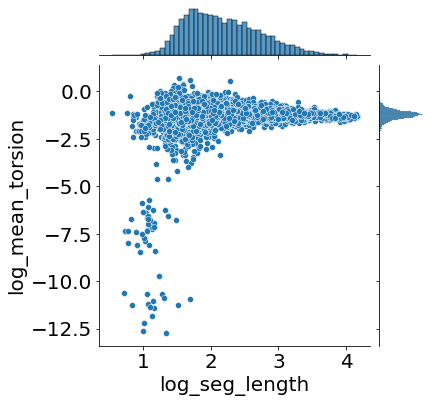

In [10]:
import seaborn as sns

g = sns.jointplot(data=df, x="log_seg_length", y="log_mean_torsion")